In [114]:
import pandas as pd
from functions import *

### 1-Préparation des données

#### &nbsp;&nbsp;a) Merger les datas en un seul dataframe

In [115]:
#charger chaque fichier, retirer les lignes vides et regarder les entetes
enron = pd.read_csv('source_data/enron.csv')
enron.dropna()
enron.head()

Message ID                       Subject  \
0           0  christmas tree farm pictures   
1           1      vastar resources , inc .   
2           2  calpine daily gas nomination   
3           3                    re : issue   
4           4     meter 7268 nov allocation   

                                             Message Spam/Ham        Date  
0                                                NaN      ham  1999-12-10  
1  gary , production from the high island larger ...      ham  1999-12-13  
2             - calpine daily gas nomination 1 . doc      ham  1999-12-14  
3  fyi - see note below - already done .\nstella\...      ham  1999-12-14  
4  fyi .\n- - - - - - - - - - - - - - - - - - - -...      ham  1999-12-14

In [116]:
ling = pd.read_csv('source_data/ling.csv')
ling= ling.dropna()
ling.head()

subject  \
0            job posting - apple-iss research center   
2  query : letter frequencies for text identifica...   
3                                               risk   
4                           request book information   
5  call for abstracts : optimality in syntactic t...   

                                             message  label  
0  content - length : 3386 apple-iss research cen...      0  
2  i am posting this inquiry for sergei atamas ( ...      0  
3  a colleague and i are researching the differin...      0  
4  earlier this morning i was on the phone with a...      0  
5  content - length : 4437 call for papers is the...      0

In [117]:
spamassassin = pd.read_csv('source_data/spamassassin.csv')
spamassassin = spamassassin[spamassassin['Body'] != 'empty']
spamassassin.head()

Unnamed: 0                                               Body  Label
0           0  \nSave up to 70% on Life Insurance.\nWhy Spend...      1
1           1  1) Fight The Risk of Cancer!\nhttp://www.adcli...      1
2           2  1) Fight The Risk of Cancer!\nhttp://www.adcli...      1
3           3  ##############################################...      1
4           4  I thought you might like these:\n1) Slim Down ...      1

In [118]:
spdivers = pd.read_csv('source_data/spam.csv')
spdivers.head()

Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...

In [119]:
#creer le dataframe 
df=pd.DataFrame()

#merger sujet et message
df["message"]=enron["Subject"]+" "+enron["Message"]
df['spam']=enron["Spam/Ham"]

#preparer les données et concatener dans le dataframe
ling_renamed=pd.DataFrame()
ling_renamed['message']=ling['subject']+ " " + ling['message']
ling_renamed['spam']=ling['label']
df = pd.concat([df, ling_renamed], ignore_index=True)

#idem pour spam assasin
spamassassin_renamed=pd.DataFrame()
spamassassin_renamed = spamassassin.rename(columns={'Body': 'message', 'Label': 'spam'})
spamassassin_renamed = spamassassin_renamed.drop(columns=["Unnamed: 0"])
df = pd.concat([df, spamassassin_renamed], ignore_index=True)

#et spdivers
spdivers_renamed = spdivers.rename(columns={'Message': 'message', 'Category': 'spam'})
df = pd.concat([df, spdivers_renamed], ignore_index=True)

df.describe()

#liberer explicitement la mémoire
del spdivers_renamed,ling_renamed,spamassassin_renamed,enron,ling,spamassassin,spdivers

In [120]:
#supprimer les messages en doublon
df = df.drop_duplicates(subset=['message'])
df.describe()

message   spam
count                        43298  43299
unique                       43298      4
top     Rofl. Its true to its name    ham
freq                             1  20378

In [121]:
#supprimer les NAN
df = df.dropna(subset=['message']).reset_index(drop=True)
#supprimer les messages de moins de 50 caracteres
df = remove_short_messages(df,'message')

In [122]:
#transformer les labels en 0:ham, 1:spam

df['spam']=df['spam'].replace({'spam':1,'ham':0,'0.0':0,'1.1':1})
df = df.drop(36195)
df = df.reset_index(drop=True)
print(df.tail())
print(df.describe())
spam_count = df['spam'].value_counts()
print("\nNombre de spam et de ham :")
print(spam_count)

                                                 message  spam
40934  Why don't you wait 'til at least wednesday to ...     0
40935  REMINDER FROM O2: To get 2.50 pounds free call...     1
40936  This is the 2nd time we have tried 2 contact u...     1
40937  Pity, * was in mood for that. So...any other s...     0
40938  The guy did some bitching but I acted like i'd...     0
               spam
count  40939.000000
mean       0.402892
std        0.490485
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

Nombre de spam et de ham :
spam
0    24445
1    16494
Name: count, dtype: int64


#### &nbsp;&nbsp;b) Ajouter des features

In [123]:
df=add_features(df)
df.head()

message  spam  message_length  \
0  vastar resources , inc . gary , production fro...     0            4307   
1  calpine daily gas nomination - calpine daily g...     0              67   
2  re : issue fyi - see note below - already done...     0            1182   
3  meter 7268 nov allocation fyi .\n- - - - - - -...     0            1150   
4  mcmullen gas for 11 / 99 jackie ,\nsince the i...     0             559   

   word_count  special_char_count  keyword_count  keyword_ratio  url_count  \
0        1577                  12              0          0.000          0   
1          12                   0              0          0.000          0   
2         347                   8              0          0.000          0   
3         322                   6              0          0.000          0   
4         125                   0              2          0.016          0   

   promo_word_count  promo_word_ratio  letter_digit_ratio  pronoun_count  \
0                 1          0.000634            4.034921             17   
1                 0          0.000000           53.000000              0   
2                 1          0.002882            8.794118             12   
3                 0          0.000000           10.474576             10   
4                 1          0.008000           16.956522              6   

   uppercase_ratio  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

#### &nbsp;&nbsp;c) Nettoyer et lemmatiser les textes

In [124]:
df=nettoyer_texte(df,'message')
df= df.dropna()
df.head()

Nettoyage des messages: 100%|██████████| 40939/40939 [21:23<00:00, 31.91it/s]  


message  spam  message_length  \
0  gary production high island large block commen...     0            4307   
1      calpine gas nomination calpine gas nomination     0              67   
2  issue fyi note .stella- forward ect    -from s...     0            1182   
3  allocation fyi forward lauri allen hou ect    ...     0            1150   
4  mcmullen gas jackie inlet river plant shut day...     0             559   

   word_count  special_char_count  keyword_count  keyword_ratio  url_count  \
0        1577                  12              0          0.000          0   
1          12                   0              0          0.000          0   
2         347                   8              0          0.000          0   
3         322                   6              0          0.000          0   
4         125                   0              2          0.016          0   

   promo_word_count  promo_word_ratio  letter_digit_ratio  pronoun_count  \
0                 1          0.000634            4.034921             17   
1                 0          0.000000           53.000000              0   
2                 1          0.002882            8.794118             12   
3                 0          0.000000           10.474576             10   
4                 1          0.008000           16.956522              6   

   uppercase_ratio  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0

### 2-Analyse des données

In [125]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer


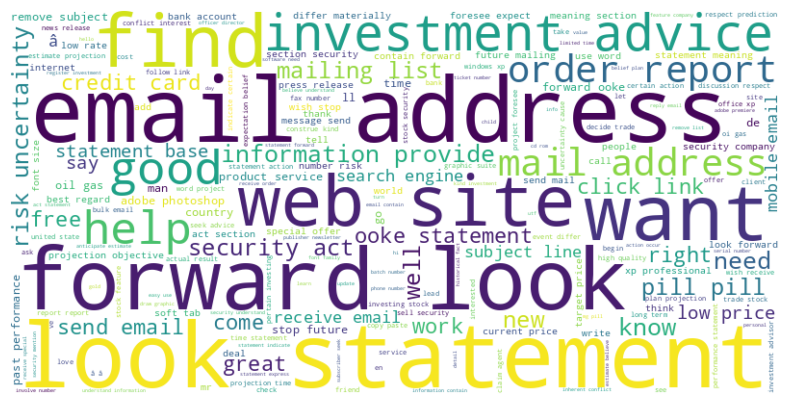

In [126]:
#petit wordcloud du spam
dfwcloud=df[df['spam']==1]
text = " ".join(message for message in dfwcloud['message'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

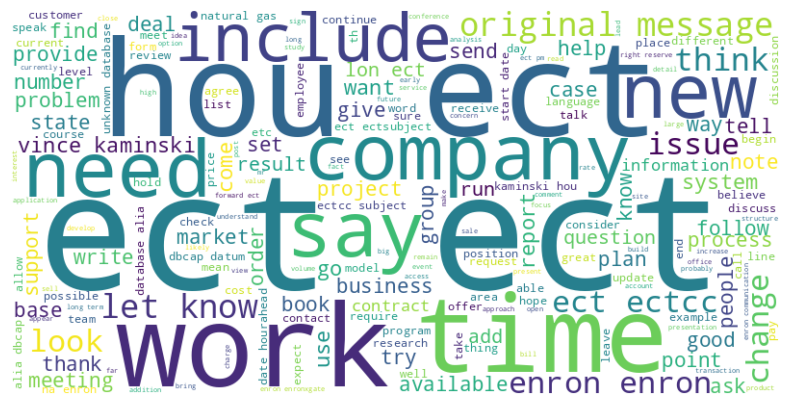

In [127]:
#petit wordcloud du ham
dfwcloud=df[df['spam']==0]
text = " ".join(message for message in dfwcloud['message'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

del dfwcloud
del wordcloud

#### &nbsp;&nbsp;a) Selection des features utiles

In [128]:
# Sélectionner les colonnes numériques sauf spam
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = [col for col in numerical_cols if col != 'spam']

In [129]:
# suppression des outliers
# quelques messages parasites sont dans le dataframe
def detect_high_outliers(df, column, nbecarttype=5):
    #Détecte les valeurs qui se trouvent à nbecarttype écarts-types au-dessus de la moyenne.

    mean = df[column].mean()
    std_dev = df[column].std()
    upper_bound = mean + nbecarttype * std_dev
    
    # Identifier les lignes avec des valeurs supérieures à `upper_bound`
    high_outliers = df[df[column] > upper_bound]
    return high_outliers, upper_bound

def detect_outliers(df, columns,nbecarttype=5):
    outlier_dict = {}
    for col in columns:
        outliers, upper = detect_high_outliers(df, col,nbecarttype)
        outlier_dict[col] = {
            'outliers': outliers,
            'upper_bound': upper
        }
    return outlier_dict

outlier_results = detect_outliers(df, numerical_cols,10)
# Résumé des résultats
for col, res in outlier_results.items():
    print(f"Colonne: {col}")
    print(f"  - Nombre d'outliers : {len(res['outliers'])}")
    print(f"  - Borne sup :  {res['upper_bound']}")
    
del outlier_results

Colonne: message_length
  - Nombre d'outliers : 61
  - Borne sup :  43367.97466717889
Colonne: word_count
  - Nombre d'outliers : 62
  - Borne sup :  8165.989962979269
Colonne: special_char_count
  - Nombre d'outliers : 62
  - Borne sup :  304.89911410238165
Colonne: keyword_count
  - Nombre d'outliers : 1
  - Borne sup :  21.5499354873279
Colonne: keyword_ratio
  - Nombre d'outliers : 43
  - Borne sup :  0.17767413684558478
Colonne: url_count
  - Nombre d'outliers : 2
  - Borne sup :  156.01345653271576
Colonne: promo_word_count
  - Nombre d'outliers : 2
  - Borne sup :  17.66991310782854
Colonne: promo_word_ratio
  - Nombre d'outliers : 41
  - Borne sup :  0.17839880168170097
Colonne: letter_digit_ratio
  - Nombre d'outliers : 34
  - Borne sup :  1587.6318404152357
Colonne: pronoun_count
  - Nombre d'outliers : 0
  - Borne sup :  82.18293667034726
Colonne: uppercase_ratio
  - Nombre d'outliers : 85
  - Borne sup :  0.4445964040828479


In [130]:
#supprimer les outliers a threshold ecart types de la moyenne
def remove_high_outliers(df, numerical_columns, threshold=5):
    for column in numerical_columns:
        mean = df[column].mean()
        std_dev = df[column].std()
        upper_bound = mean + threshold * std_dev
        
        # Supprimer les outliers qui sont au-dessus de la limite supérieure
        df = df[df[column] <= upper_bound]
    
    return df

# Sélectionner les colonnes numériques (externe à la fonction)
numerical_columns = df.select_dtypes(include=['number']).columns

df=remove_high_outliers(df,numerical_cols,5)#On supprime a 5 ecart type


In [131]:
df.describe()

spam  message_length    word_count  special_char_count  \
count  39059.000000    39059.000000  39059.000000        39059.000000   
mean       0.396887     1278.129701    254.980337            3.841112   
std        0.489258     1586.587055    311.763880            9.190245   
min        0.000000       50.000000      1.000000            0.000000   
25%        0.000000      329.000000     64.000000            0.000000   
50%        0.000000      726.000000    144.000000            1.000000   
75%        1.000000     1553.000000    314.000000            4.000000   
max        1.000000    17248.000000   2296.000000          117.000000   

       keyword_count  keyword_ratio     url_count  promo_word_count  \
count   39059.000000   39059.000000  39059.000000      39059.000000   
mean        1.117745       0.006494      0.178883          1.141376   
std         1.685889       0.011834      0.656294          1.373988   
min         0.000000       0.000000      0.000000          0.000000   
25%         0.000000       0.000000      0.000000          0.000000   
50%         0.000000       0.000000      0.000000          1.000000   
75%         2.000000       0.008197      0.000000          2.000000   
max        10.000000       0.090909      6.000000          8.000000   

       promo_word_ratio  letter_digit_ratio  pronoun_count  uppercase_ratio  
count      39059.000000        39059.000000   39059.000000     39059.000000  
mean           0.007436           54.591543      12.713766         0.008804  
std            0.011887           92.936382       6.566069         0.023321  
min            0.000000            0.000000       0.000000         0.000000  
25%            0.000000            6.600000       8.000000         0.000000  
50%            0.002907           22.500000      13.000000         0.000000  
75%            0.009615           59.622507      17.000000         0.000000  
max            0.078431          826.000000      39.000000         0.222222

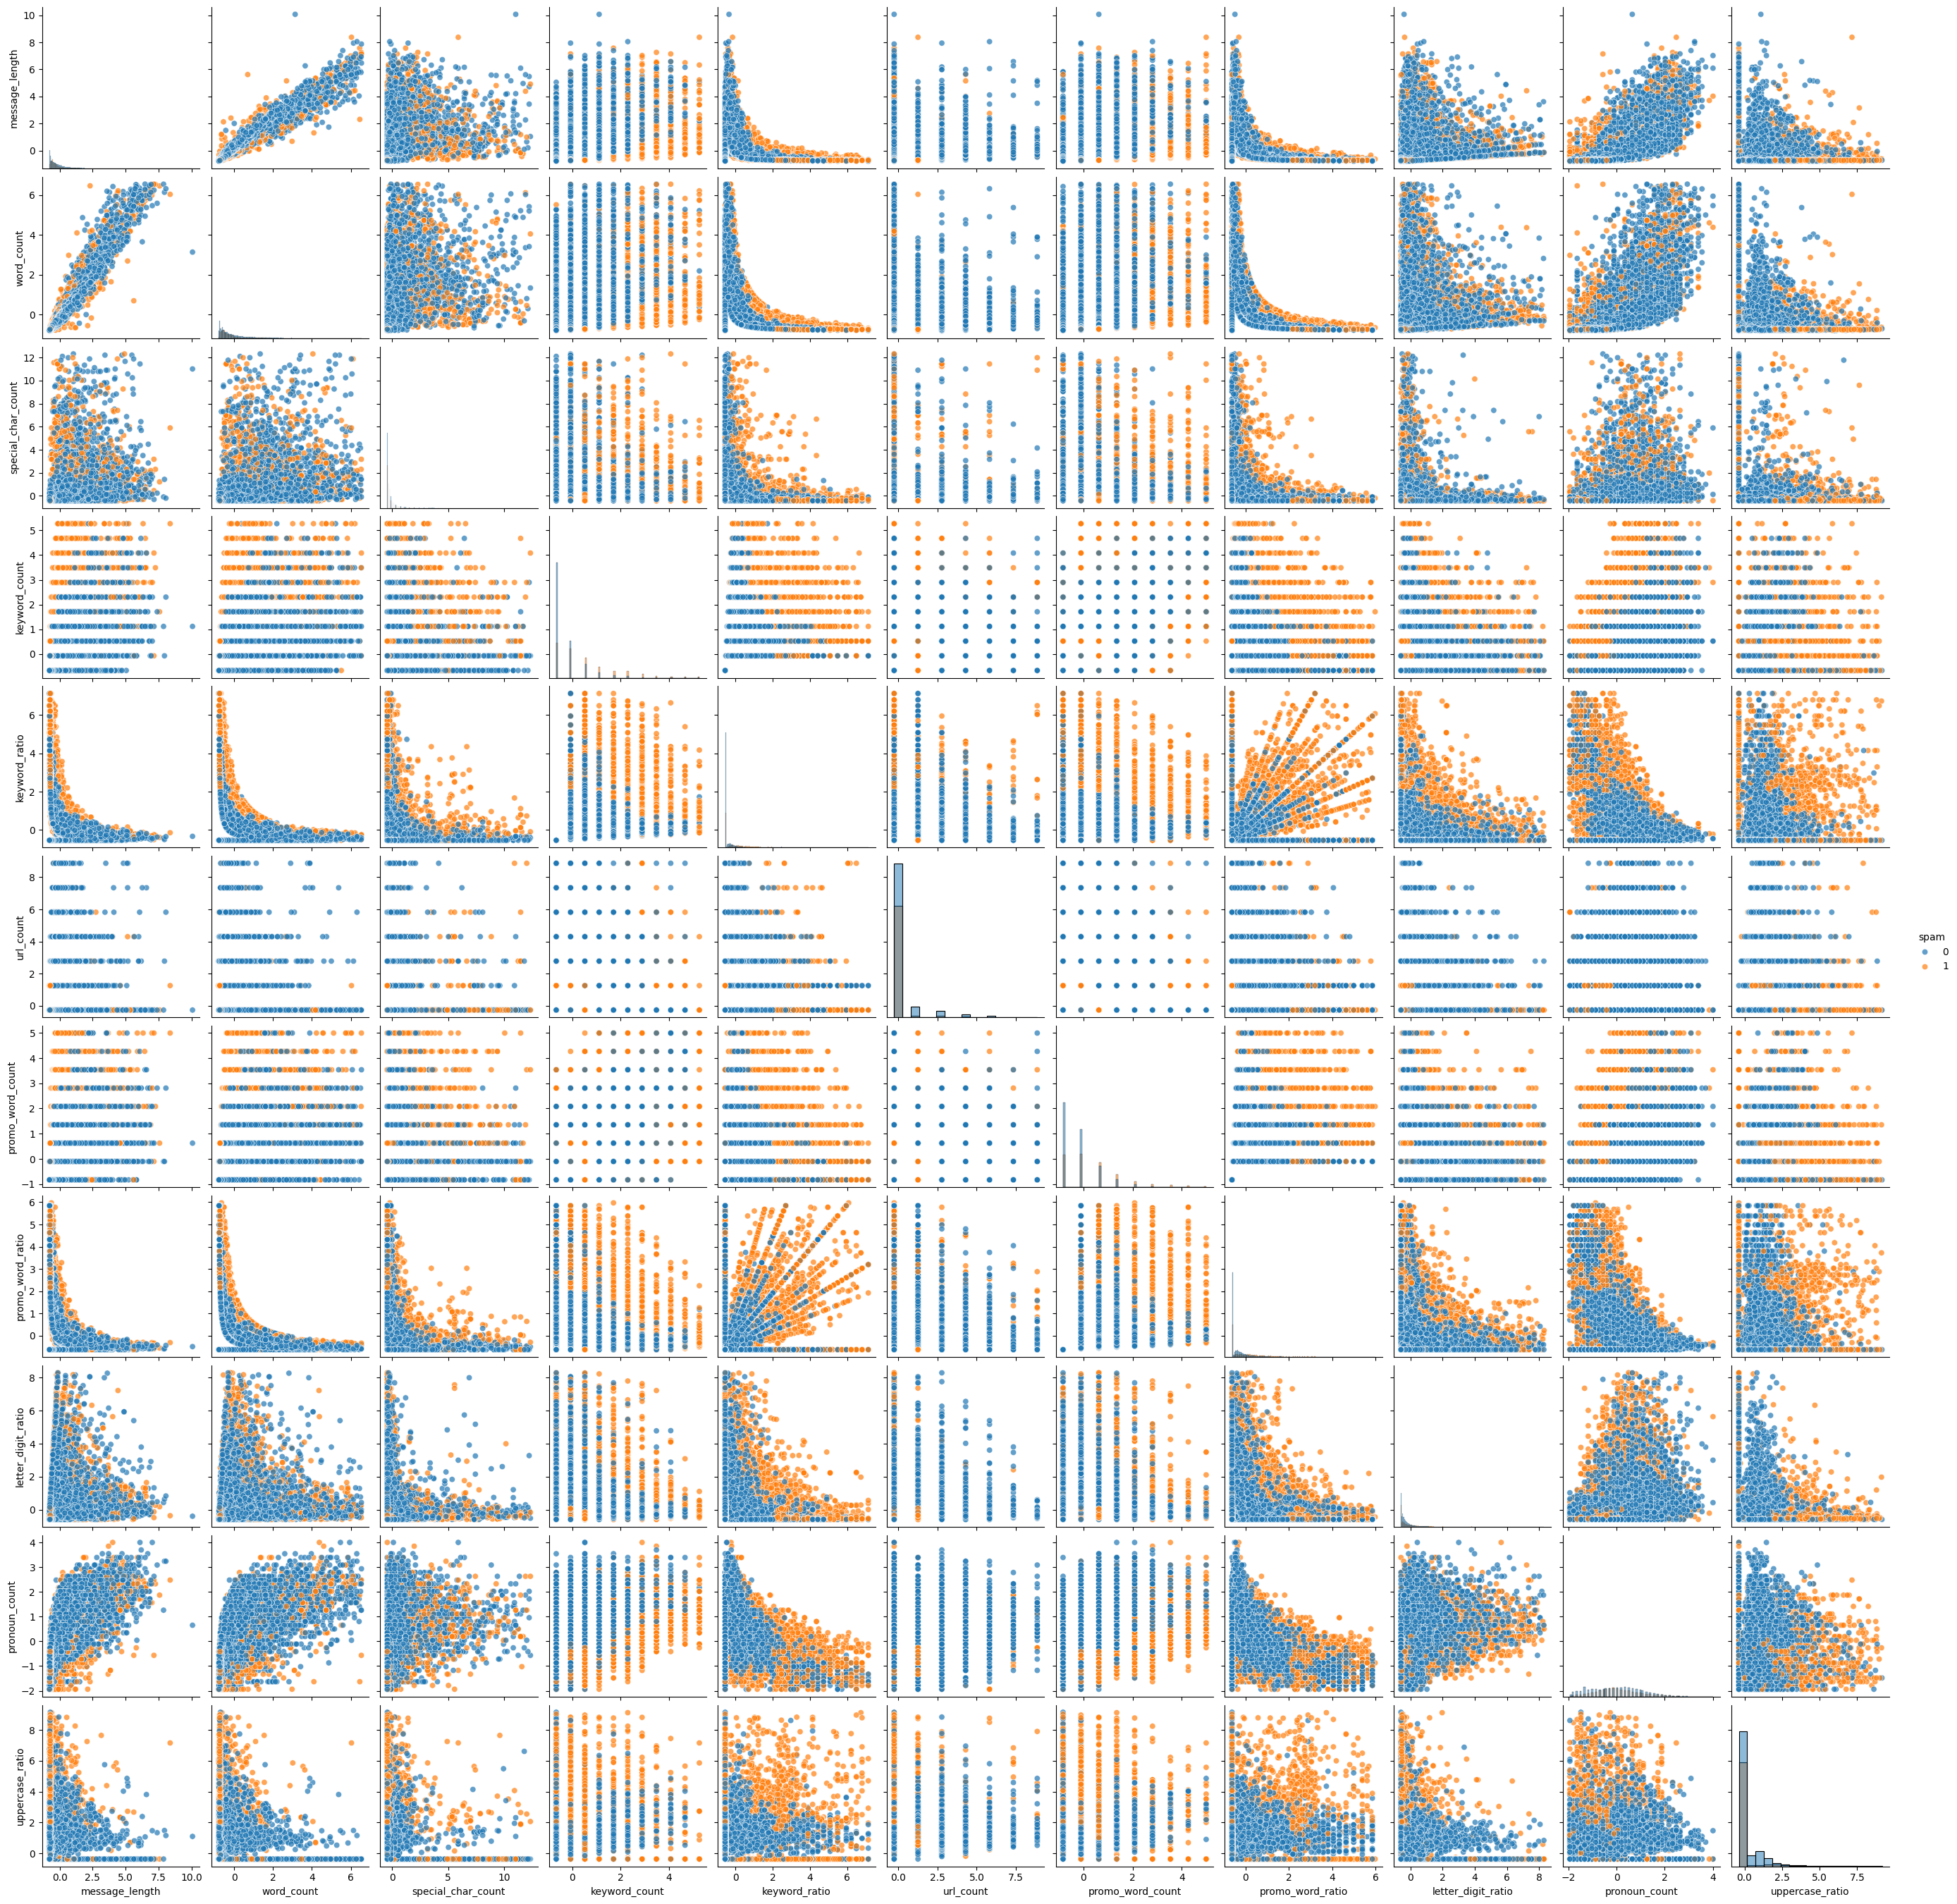

In [132]:
# Créer une copie du DataFrame pour ne pas modifier l'original et Standardiser les colonnes numériques
df_standardized = df.copy()


scaler = StandardScaler()
df_standardized[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Afficher un pairplot avec les données standardisées
sns.pairplot(df_standardized, hue="spam", kind="scatter", diag_kind="hist",plot_kws={'alpha': 0.7})

In [133]:
# Nous ne conserverons que les colonnes qui semblent avoir un lien de correlation et supprimons donc les autres (on oublie pas de garder message et spam)
numerical_features=['keyword_count', 'keyword_ratio', 'promo_word_count', 'promo_word_ratio', 'uppercase_ratio']
tokeep = numerical_features + ['spam', 'message']
# Filtrer les colonnes à garder dans 'numerical_cols'
columns_to_drop = [col for col in numerical_cols if col not in tokeep]
# Supprimer les colonnes qui ne sont pas dans 'tokeep'
df_cleaned = df.drop(columns=columns_to_drop)

del df_standardized,df_cleaned


#### &nbsp;&nbsp;b) Analyse PCA des données textuelles (message)

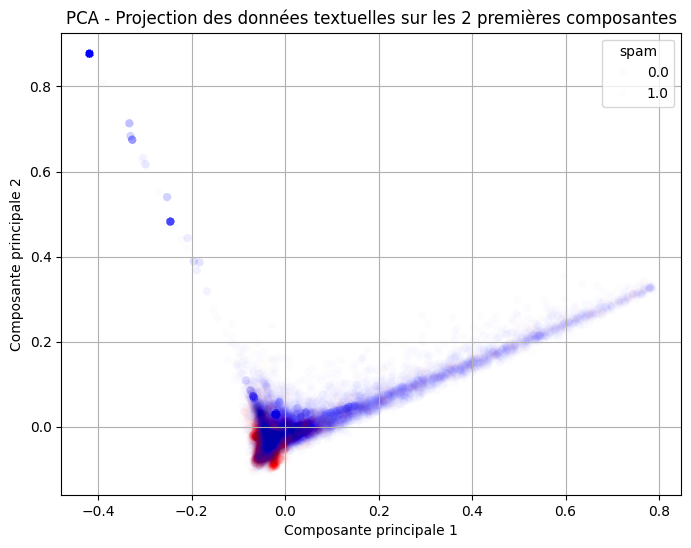

In [134]:
# Convertir la colonne 'text' en vecteurs numériques avec TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  
X = vectorizer.fit_transform(df['message'])

# Appliquer le PCA pour réduire la dimensionnalité à 2
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X.toarray()) 

# Créer un DataFrame avec les 2 premières composantes principales
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['spam'] = df['spam']  # Ajouter la colonne 'spam' pour la colorisation

plt.figure(figsize=(8, 6))

# Plot avec coloration en fonction de la colonne 'spam'
sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue='spam', palette={0: 'blue', 1: 'red'}, alpha=0.01)


# Ajouter des labels et un titre
plt.title("PCA - Projection des données textuelles sur les 2 premières composantes")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.show()

#### &nbsp;&nbsp;C) Analyse PCA des données numeriques

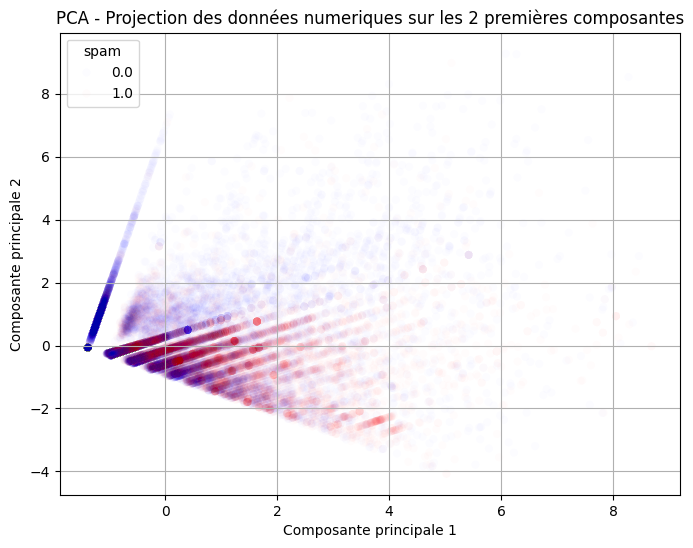

In [135]:
X = df[numerical_features]

# Normaliser les données avant d'appliquer le PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Appliquer le PCA pour réduire à 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Créer un DataFrame avec les composantes principales
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['spam']= df['spam']
# Visualiser les 2 premières composantes principales
plt.figure(figsize=(8, 6))
sns.scatterplot(x='PC1', y='PC2', data=df_pca, hue='spam', palette={0: 'blue', 1: 'red'}, alpha=0.01)
plt.title("PCA - Projection des données numeriques sur les 2 premières composantes")
plt.xlabel("Composante principale 1")
plt.ylabel("Composante principale 2")
plt.grid(True)
plt.show()

### 3-Selectionner un modèle

Tous les modèles présentés ont été fine-tuné avec un grid search cross validation et des valeurs autour des valeurs par defaut des modèles

#### &nbsp;&nbsp;A) Séparation du jeu de données en train et test

In [136]:
from sklearn.model_selection import train_test_split

In [137]:
X=df[numerical_features+['message']]
y=df['spam']
#separation du jeu de données en train (80%) et test(20%), stratify fait en sorte que les classes soit répartie proportionellement
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

#### &nbsp;&nbsp;B) Création du pipeline

In [138]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer


In [139]:
models_to_test=['mnb','sgd','rf','xgboost']

In [140]:
def create_pipeline(modelname='sgd'):
    #chaque modele va préprocesser de la même manière
    preprocessor=ColumnTransformer(
            transformers=[
                ('text', TfidfVectorizer(max_features=5000), 'message'),  # Transformation des messages textuels
                ('num', StandardScaler(), numerical_features)  # Normalisation des colonnes numériques
            ])
    
    if(modelname=='sgd'):
        return Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('sgd', SGDClassifier(alpha=0.0001,loss='log_loss',max_iter=1000,penalty='l2'))  # Classificateur SGD
        #alpha : controle l'intensité de la régularisation appliquée au modele, 0,0001 => faible laisse le modèle sans trop de contrainte, peu donc creer des choses complexes et risque d'overfitting
        #loss: perte logistique (log_loss mesure l'écart entre les probabilités prédites et les vraies etiquettes)
        #penalty: l2 (reduit l'importance des caracteristiques moins pertinentes, favorise les modèles plus simples, réduit le risque d'overfitting)
        #max_iter : nombre d'iterations pendant lesquelles l'agorithme va ajuster les poids (trop faible => convergence prématurée, trop grand=>risque d'overfitting)
        ])
    elif(modelname=='rf'):
        return Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('rf', RandomForestClassifier(n_estimators=500,random_state=42,max_depth=30,min_samples_leaf=1,min_samples_split=5))  # Random Forrest
        #n_estimators : nombre d'arbres, plus il y a d'arbres plus le risque d'overfitting est réduit, plus il sera robuste.
        #min_samples_leaf : nombre d'échantillon dans une feuille (noeud terminal)
        #min_samples_split : nombres d'echantillons minimum pour permettre au noeud de se diviser
        ])
    elif(modelname=='mnb'):
        #sauf multinomial naives bayes qui a besoin de nombres positifs uniquement
        preprocessor=ColumnTransformer(
                transformers=[
                    ('text', TfidfVectorizer(max_features=5000, norm=None), 'message'),  # Transformation des messages textuels, on ne normalise pas
                    ('num', 'passthrough', numerical_features)  # on ne normalise pas les features numeriques 
                ])
        return Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('mnb', MultinomialNB(alpha=1,fit_prior=False)) #Multinomial Naïve Baye
        #fit_prior: indique si les probabilités doivent etre apprises a partir des données d'entrainement ou non : False: le mod_le suppose qu'au début toutes les classes sont également probables. (insensible à la distribution des classes dans les données)
        ])
    else:
        return Pipeline(steps=[
        ('preprocessor',preprocessor),
        ('xgboost', XGBClassifier( eval_metric='logloss', random_state=42,objective="binary:logistic",learning_rate=0.2,max_depth=7,n_estimators=300))  # Étape 2 : XGBoost
        #eval_metric: logloss : fonction de mesure de la performance, logloss=perte logarithmique, adaptée car tien compte des probabilités prédites pas seulement des décision binaires.
    ])


#### &nbsp;&nbsp;C) Entrainer les modèles et prédire

In [141]:
import joblib


In [142]:
def entrainer_evaluer_model(X, y, model_name):
    pipe = create_pipeline(model_name)
    
    scoring = {
        'f1': 'f1',
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall'
    }
    
    cv_results = cross_validate(
        pipe, X, y,
        cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        scoring=scoring,
        return_train_score=True,
        n_jobs=-1,
        verbose=3
    )
    
    # Fit the model on the full dataset for later use
    pipe.fit(X, y)
    
    return pipe, cv_results

In [143]:
from sklearn.model_selection import cross_validate, learning_curve

In [144]:
predictions_results={}
models={}
results_cv={}


for model_to_test in models_to_test:
    pipe, cv_results = entrainer_evaluer_model(X_train, y_train, model_to_test)
    models[model_to_test] = pipe
    results_cv[model_to_test] = cv_results
    predictions_results[model_to_test]=pipe.predict(X_test)
    joblib.dump(pipe, model_to_test+'.joblib')
    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END  accuracy: (train=0.936, test=0.927) f1: (train=0.922, test=0.910) precision: (train=0.894, test=0.883) recall: (train=0.952, test=0.940) total time=   3.7s
[CV] END  accuracy: (train=0.936, test=0.938) f1: (train=0.921, test=0.925) precision: (train=0.897, test=0.898) recall: (train=0.947, test=0.953) total time=   3.8s
[CV] END  accuracy: (train=0.936, test=0.928) f1: (train=0.922, test=0.913) precision: (train=0.894, test=0.882) recall: (train=0.951, test=0.946) total time=   3.8s
[CV] END  accuracy: (train=0.936, test=0.932) f1: (train=0.922, test=0.916) precision: (train=0.895, test=0.890) recall: (train=0.950, test=0.944) total time=   3.7s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    7.5s remaining:   11.3s


[CV] END  accuracy: (train=0.936, test=0.931) f1: (train=0.922, test=0.915) precision: (train=0.893, test=0.893) recall: (train=0.954, test=0.938) total time=   2.1s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END  accuracy: (train=0.961, test=0.955) f1: (train=0.950, test=0.942) precision: (train=0.965, test=0.960) recall: (train=0.935, test=0.925) total time=   3.2s
[CV] END  accuracy: (train=0.962, test=0.953) f1: (train=0.952, test=0.941) precision: (train=0.959, test=0.951) recall: (train=0.944, test=0.931) total time=   3.8s
[CV] END  accuracy: (train=0.965, test=0.957) f1: (train=0.955, test=0.945) precision: (train=0.967, test=0.962) recall: (train=0.944, test=0.927) total time=   4.1s


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    6.4s remaining:    9.6s


[CV] END  accuracy: (train=0.960, test=0.948) f1: (train=0.948, test=0.933) precision: (train=0.964, test=0.949) recall: (train=0.933, test=0.918) total time=   4.2s
[CV] END  accuracy: (train=0.965, test=0.955) f1: (train=0.955, test=0.942) precision: (train=0.970, test=0.965) recall: (train=0.940, test=0.919) total time=   2.5s


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    9.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END  accuracy: (train=0.958, test=0.940) f1: (train=0.945, test=0.920) precision: (train=0.989, test=0.972) recall: (train=0.904, test=0.873) total time= 1.3min
[CV] END  accuracy: (train=0.958, test=0.939) f1: (train=0.944, test=0.919) precision: (train=0.989, test=0.974) recall: (train=0.904, test=0.869) total time= 1.3min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.4min remaining:  2.2min


[CV] END  accuracy: (train=0.958, test=0.939) f1: (train=0.945, test=0.919) precision: (train=0.988, test=0.974) recall: (train=0.905, test=0.870) total time= 1.4min
[CV] END  accuracy: (train=0.956, test=0.939) f1: (train=0.943, test=0.920) precision: (train=0.989, test=0.968) recall: (train=0.900, test=0.876) total time= 1.4min
[CV] END  accuracy: (train=0.957, test=0.937) f1: (train=0.944, test=0.916) precision: (train=0.987, test=0.969) recall: (train=0.904, test=0.869) total time= 1.2min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[CV] END  accuracy: (train=0.994, test=0.975) f1: (train=0.992, test=0.969) precision: (train=0.992, test=0.964) recall: (train=0.993, test=0.973) total time= 2.4min
[CV] END  accuracy: (train=0.994, test=0.975) f1: (train=0.992, test=0.969) precision: (train=0.991, test=0.968) recall: (train=0.993, test=0.969) total time= 2.4min


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  2.5min remaining:  3.7min


[CV] END  accuracy: (train=0.994, test=0.974) f1: (train=0.992, test=0.967) precision: (train=0.991, test=0.965) recall: (train=0.993, test=0.970) total time= 2.4min
[CV] END  accuracy: (train=0.994, test=0.974) f1: (train=0.993, test=0.967) precision: (train=0.992, test=0.962) recall: (train=0.994, test=0.972) total time= 2.4min
[CV] END  accuracy: (train=0.994, test=0.973) f1: (train=0.992, test=0.967) precision: (train=0.991, test=0.965) recall: (train=0.994, test=0.968) total time= 1.7min


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  4.2min finished


#### &nbsp;&nbsp;D) Entrainer et Comparer les résultats

In [145]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score

Modèle testé :  mnb

Cross-validation Results:
F1:
  Train: 0.922 (+/- 0.000)
  Test:  0.916 (+/- 0.005)
Accuracy:
  Train: 0.936 (+/- 0.000)
  Test:  0.931 (+/- 0.004)
Precision:
  Train: 0.895 (+/- 0.001)
  Test:  0.889 (+/- 0.006)
Recall:
  Train: 0.951 (+/- 0.002)
  Test:  0.944 (+/- 0.005)


Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.92      0.94      4712
           1       0.88      0.94      0.91      3100

    accuracy                           0.93      7812
   macro avg       0.92      0.93      0.92      7812
weighted avg       0.93      0.93      0.93      7812


Confusion Matrix:


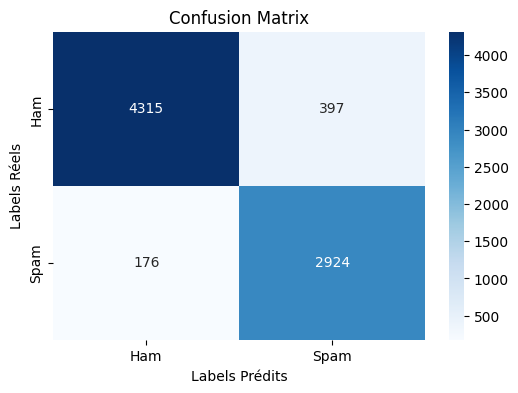

Modèle testé :  sgd

Cross-validation Results:
F1:
  Train: 0.952 (+/- 0.003)
  Test:  0.940 (+/- 0.004)
Accuracy:
  Train: 0.962 (+/- 0.002)
  Test:  0.954 (+/- 0.003)
Precision:
  Train: 0.965 (+/- 0.003)
  Test:  0.957 (+/- 0.006)
Recall:
  Train: 0.939 (+/- 0.005)
  Test:  0.924 (+/- 0.005)


Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96      4712
           1       0.96      0.92      0.94      3100

    accuracy                           0.95      7812
   macro avg       0.96      0.95      0.95      7812
weighted avg       0.95      0.95      0.95      7812


Confusion Matrix:


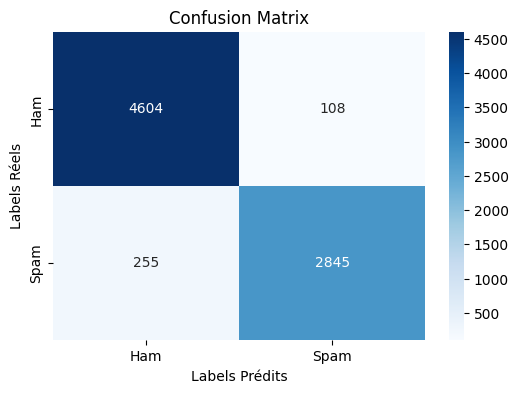

Modèle testé :  rf

Cross-validation Results:
F1:
  Train: 0.944 (+/- 0.001)
  Test:  0.919 (+/- 0.001)
Accuracy:
  Train: 0.957 (+/- 0.001)
  Test:  0.939 (+/- 0.001)
Precision:
  Train: 0.989 (+/- 0.001)
  Test:  0.971 (+/- 0.003)
Recall:
  Train: 0.903 (+/- 0.002)
  Test:  0.871 (+/- 0.003)


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4712
           1       0.97      0.86      0.91      3100

    accuracy                           0.94      7812
   macro avg       0.94      0.92      0.93      7812
weighted avg       0.94      0.94      0.94      7812


Confusion Matrix:


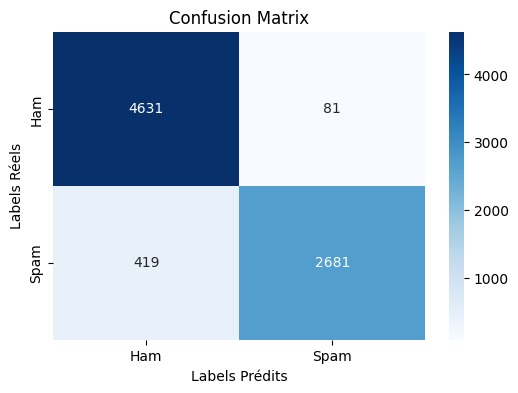

Modèle testé :  xgboost

Cross-validation Results:
F1:
  Train: 0.992 (+/- 0.000)
  Test:  0.968 (+/- 0.001)
Accuracy:
  Train: 0.994 (+/- 0.000)
  Test:  0.974 (+/- 0.001)
Precision:
  Train: 0.991 (+/- 0.001)
  Test:  0.965 (+/- 0.002)
Recall:
  Train: 0.993 (+/- 0.000)
  Test:  0.970 (+/- 0.002)


Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4712
           1       0.97      0.97      0.97      3100

    accuracy                           0.98      7812
   macro avg       0.98      0.98      0.98      7812
weighted avg       0.98      0.98      0.98      7812


Confusion Matrix:


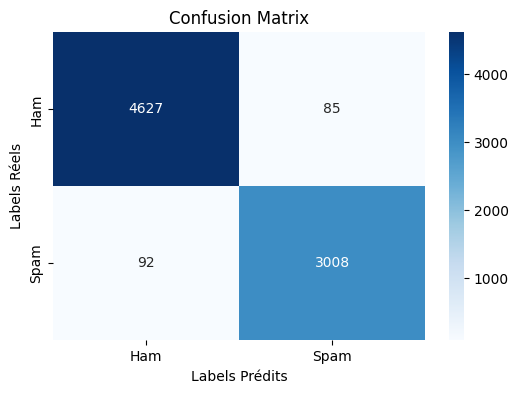

In [146]:
f1scores={}
for model_to_test in models_to_test:
    y_pred=predictions_results[model_to_test]
    print("Modèle testé : ",model_to_test)

    #cv_scores
    cv_results=results_cv[model_to_test]
    print("\nCross-validation Results:")
    for metric in ['f1', 'accuracy', 'precision', 'recall']:
        mean_train = cv_results[f'train_{metric}'].mean()
        std_train = cv_results[f'train_{metric}'].std()
        mean_test = cv_results[f'test_{metric}'].mean()
        std_test = cv_results[f'test_{metric}'].std()
        
        print(f"{metric.capitalize()}:")
        print(f"  Train: {mean_train:.3f} (+/- {std_train:.3f})")
        print(f"  Test:  {mean_test:.3f} (+/- {std_test:.3f})")
    
    #classification report
    print("\n\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    f1scores[model_to_test]=f1_score(y_test, y_pred)
    #matrice de confusion
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("\nConfusion Matrix:")
    class_labels = ['Ham', 'Spam']

    # Créer une figure pour la heatmap
    plt.figure(figsize=(6, 4))

    # Afficher la matrice de confusion en tant que heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Labels Prédits')
    plt.ylabel('Labels Réels')
    # Afficher la figure
    plt.show()
    
    

#### &nbsp;&nbsp;E) Learning curves

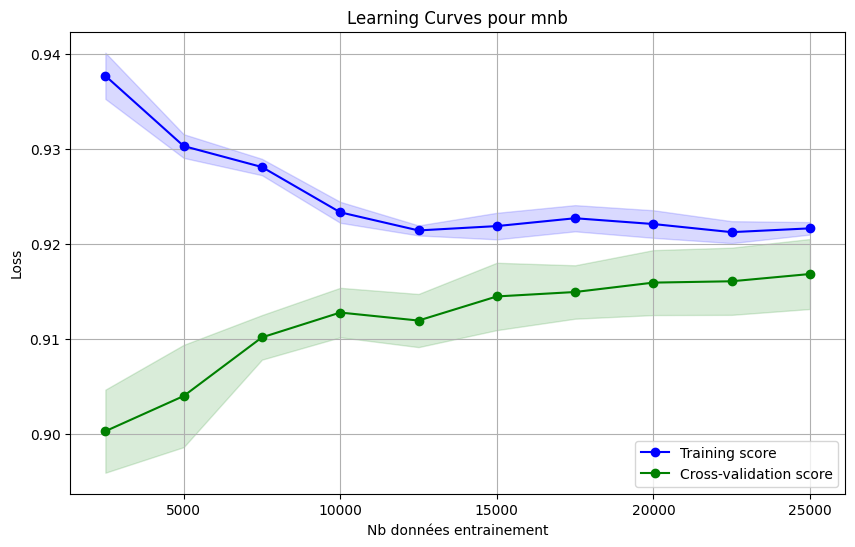

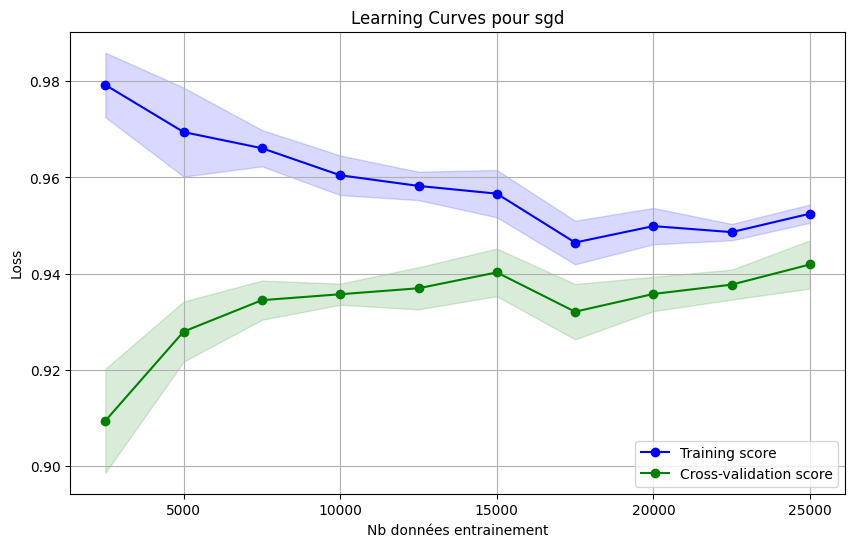

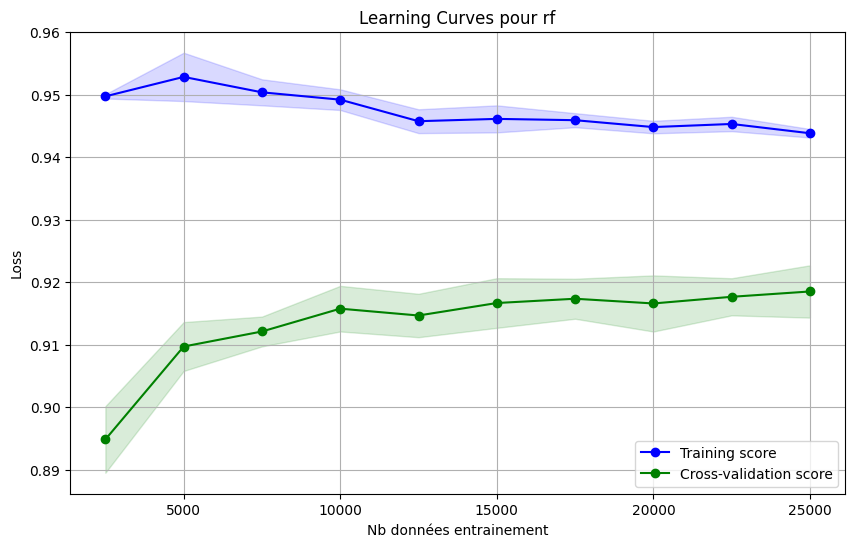

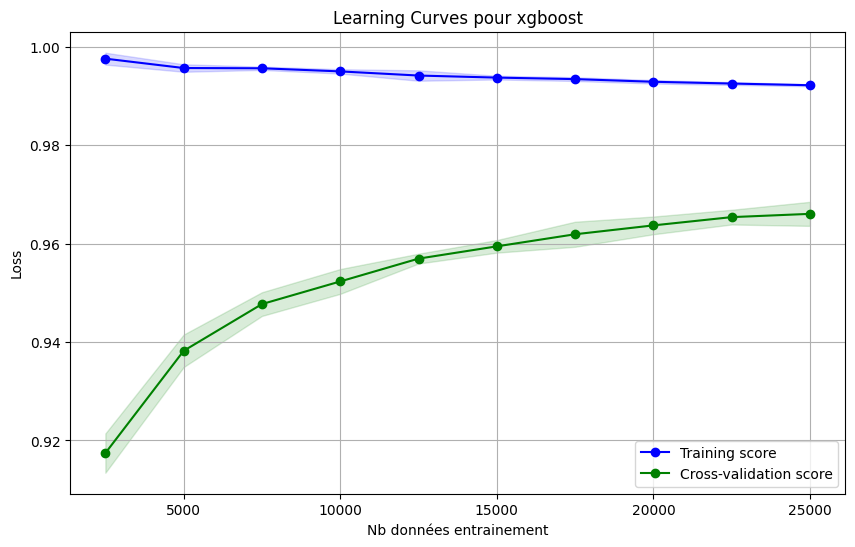

In [147]:
#la fonction learning_curve reentraine le modèle en analysant la quantité de données nécessaires
#ainsi si on arrive vite au plancher on sait que le modele overfit ou alors on peut deviner combien de data il faudrait pour encore amméiorer
#tracer le f1 score est plus pertinent que la loss, car celà tient compte de la précision et du rappel
for model_to_test in models_to_test:
    pipe = create_pipeline(model_to_test)
    
    train_sizes, train_scores, test_scores = learning_curve(
        pipe, X_train, y_train,
        train_sizes=np.linspace(0.1, 1.0, 10),
        cv=5,
        n_jobs=-1,
        scoring='f1'
    )
    
    # calcule les moyennes et ecarts types
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    
    # dessiner
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_mean, label='Training score', color='blue', marker='o')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='blue', alpha=0.15)
    plt.plot(train_sizes, test_mean, label='Cross-validation score', color='green', marker='o')
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='green', alpha=0.15)
    
    plt.title(f'Learning Curves pour {model_to_test}')
    plt.xlabel('Nb données entrainement')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()


#### &nbsp;&nbsp;F) Impact des features sur les prédictions

/tmp/ipykernel_7738/1783542626.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_values, y=feature_groups, palette='coolwarm')


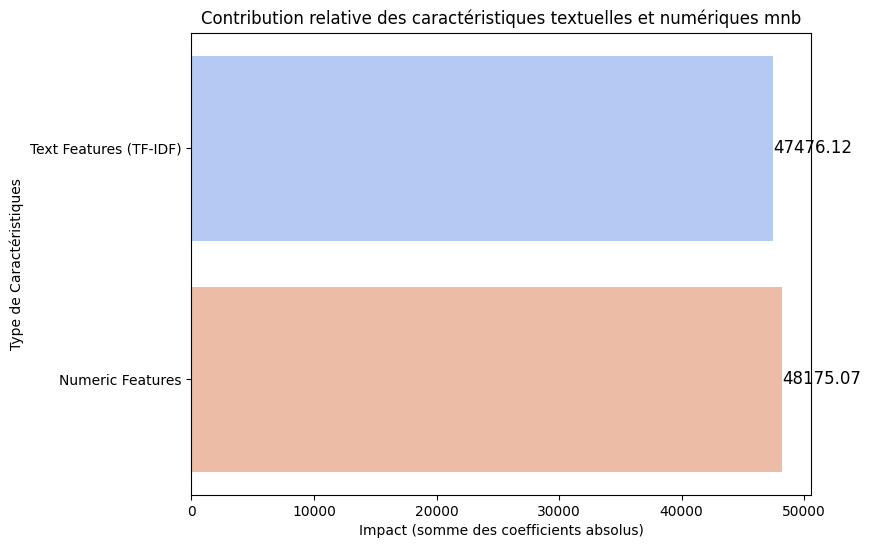

/tmp/ipykernel_7738/1783542626.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_values, y=feature_groups, palette='coolwarm')


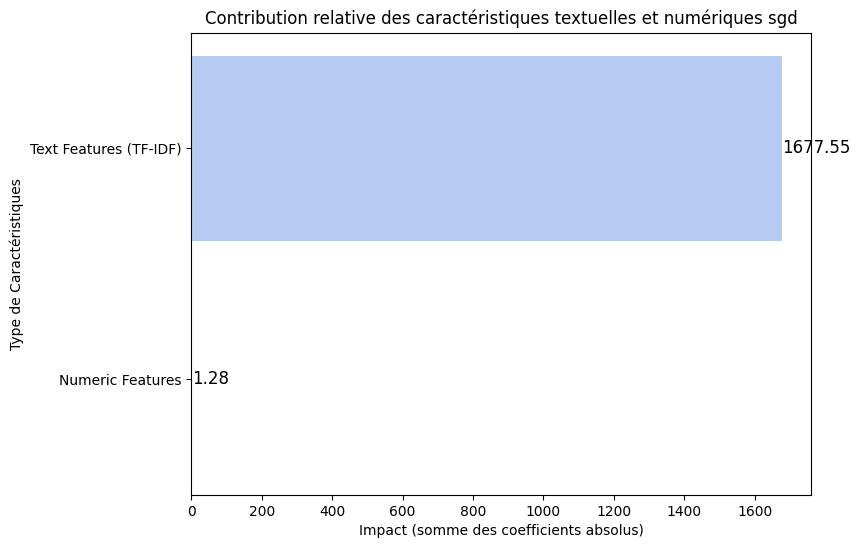

/tmp/ipykernel_7738/1783542626.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_values, y=feature_groups, palette='coolwarm')


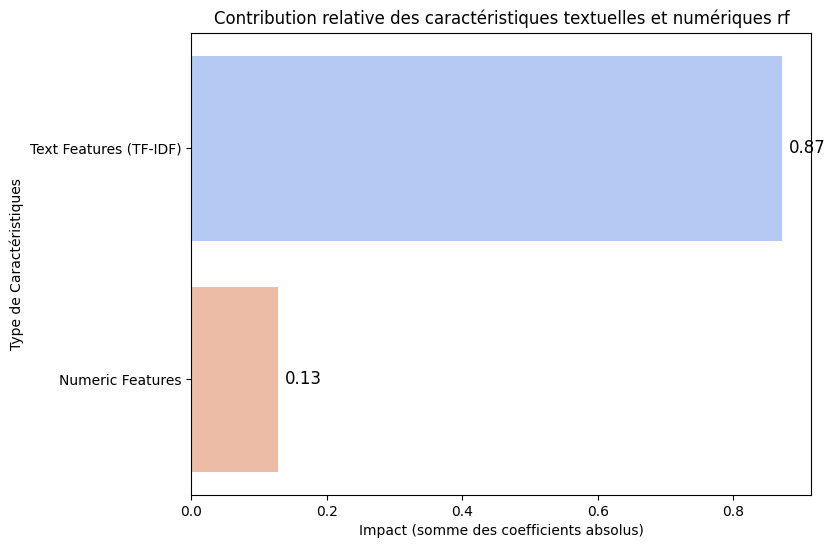

/tmp/ipykernel_7738/1783542626.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance_values, y=feature_groups, palette='coolwarm')


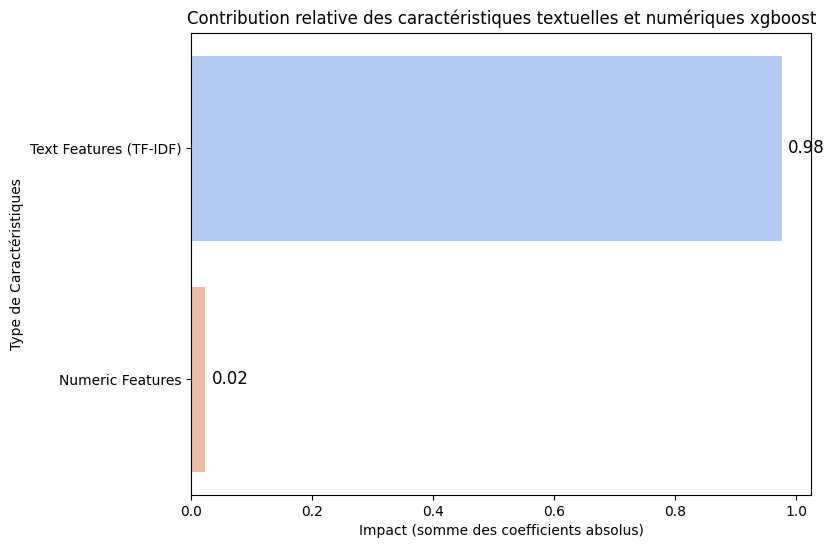

In [148]:
for model_to_test in models_to_test:
    savedpipeline=models[model_to_test]
    
    # Extraire les caractéristiques textuelles
    text_feature_names = savedpipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
    
    if model_to_test=="sgd":
        text_coefficients = savedpipeline.named_steps[model_to_test].coef_.flatten()[:len(text_feature_names)] #flatten (applati la matrice) et ne prendre que les coefficient textuels
    elif model_to_test=="mnb":
        text_coefficients = savedpipeline.named_steps[model_to_test].feature_log_prob_.flatten()[:len(text_feature_names)] 
    else:
        text_coefficients = savedpipeline.named_steps[model_to_test].feature_importances_.flatten()[:len(text_feature_names)]
    
    # Extraire les caractéristiques numériques
    numeric_feature_names = ['keyword_count', 'keyword_ratio', 'pronoun_count', 'pronoun_ratio', 'uppercase_ratio']
    if model_to_test=="sgd":
        numeric_coefficients = savedpipeline.named_steps[model_to_test].coef_.flatten()[len(text_feature_names):]
    elif model_to_test=="mnb":
        numeric_coefficients = savedpipeline.named_steps[model_to_test].feature_log_prob_.flatten()[len(text_feature_names):]
    else:
        numeric_coefficients = savedpipeline.named_steps[model_to_test].feature_importances_.flatten()[len(text_feature_names):]

    # Combiner les caractéristiques textuelles et numériques
    all_feature_names = list(text_feature_names) + numeric_feature_names
    all_coefficients = np.concatenate([text_coefficients, numeric_coefficients])
    # Diviser l'importance en deux groupes : textuelles et numériques
    text_total_importance = np.sum(np.abs(text_coefficients))
    numeric_total_importance = np.sum(np.abs(numeric_coefficients))

    # Préparer les données pour le graphique
    feature_groups = ['Text Features (TF-IDF)', 'Numeric Features']
    importance_values = [text_total_importance, numeric_total_importance]

    # Créer un barplot
    plt.figure(figsize=(8, 6))
    sns.barplot(x=importance_values, y=feature_groups, palette='coolwarm')

    # Ajouter des annotations
    for i, v in enumerate(importance_values):
        plt.text(v + 0.01, i, f"{v:.2f}", color='black', va='center', fontsize=12)

    # Ajouter des labels et un titre
    plt.xlabel('Impact (somme des coefficients absolus)')
    plt.ylabel('Type de Caractéristiques')
    plt.title('Contribution relative des caractéristiques textuelles et numériques '+model_to_test)

    # Afficher le graphique
    plt.show()

#### &nbsp;&nbsp;G) Sauvegarder le meilleur modèle

In [149]:
import os
import shutil

In [150]:
best_model = max(f1scores, key=f1scores.get)
best_f1score = f1scores[best_model]
print(f"\nLe modèle avec le F1-score le plus élevé est '{best_model}' avec un F1-score de {best_f1score} il a été sauvegardé dans spam.joblib")

#renommage du gagnant et suppression des perdants
shutil.move(model_to_test+'.joblib', 'spam.joblib')
for model_to_test in models_to_test:
    if os.path.exists(model_to_test+'.joblib'):
        os.remove(model_to_test+'.joblib')


Le modèle avec le F1-score le plus élevé est 'xgboost' avec un F1-score de 0.9714193444211208 il a été sauvegardé dans spam.joblib
